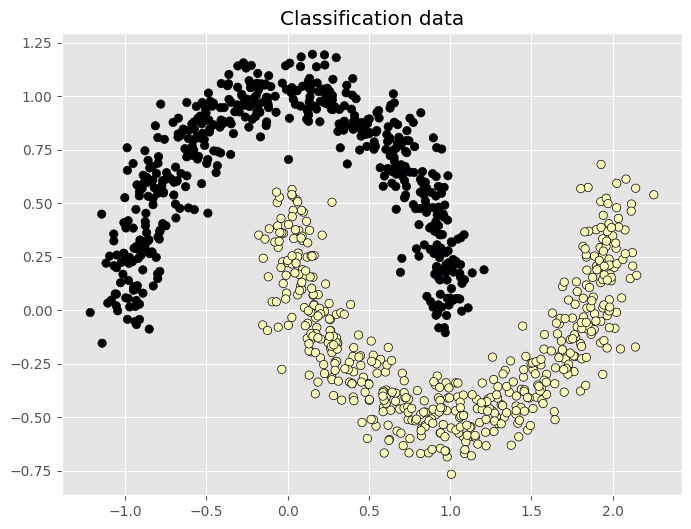

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

%matplotlib inline

plt.style.use('ggplot')

data, targets = make_moons(n_samples=1024, noise=0.1, random_state=2)
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=targets, cmap='magma', edgecolors='k')
plt.title('Classification data');


In [ ]:
def plot_moon_clf_progress(model, data, losses, accuracy):

    clear_output(True)
    f, ((ax11, ax12), (ax21, ax22)) = plt.subplots(nrows=2, ncols=2,)
    f.set_figheight(12)
    f.set_figwidth(12)

    margin = 0.1
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()

    X, Y = np.meshgrid(
        np.linspace(x_min - margin, x_max + margin),
        np.linspace(y_min - margin, y_max + margin),
    )

    preds = model(torch.tensor(np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])).float())
    proba_preds = preds.detach().numpy()
    Z = proba_preds.reshape((X.shape[0], X.shape[0]))

    ax11.plot(losses)
    ax11.set_title('Loss')

    ax12.plot(accuracy)
    ax12.set_title('Accuracy')

    ax21.contourf(X, Y, Z, levels=30)
    ax21.scatter(data[:, 0], data[:, 1], c=targets, cmap='magma', edgecolors='w')
    ax21.set_title('Probability predictions')

    ax22.contourf(X, Y, (Z > 0.5).astype(int), levels=2)
    ax22.scatter(data[:, 0], data[:, 1], c=targets, cmap='magma', edgecolors='w')
    ax22.set_title('Classification ($p > 0.5$)')


    plt.show()

In [ ]:
class MoonsClassifier(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(MoonsClassifier, self).__init__()

        self.flatten = nn.Flatten()

        self.input_layer = nn.Linear(input_size, 16)
        self.input_activation = nn.ReLU()

        self.hidden_layer = nn.Linear(16, 16)
        self.hidden_activation = nn.ReLU()

        self.output = nn.Linear(16, output_size)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):

        x = self.flatten(x)
        x = self.input_layer(x)
        x = self.input_activation(x)

        x = self.hidden_layer(x)
        x = self.hidden_activation(x)

        x = self.output(x)
        x = self.output_activation(x)

        return x

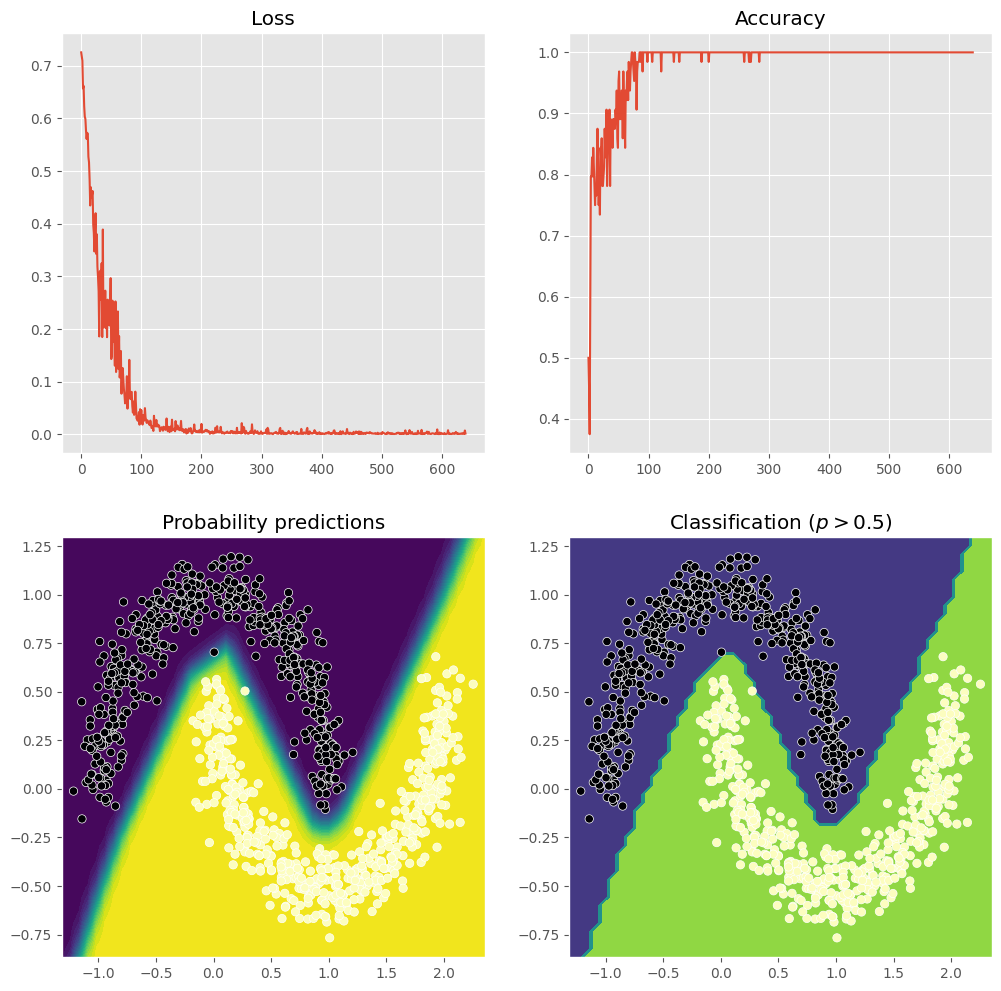

In [ ]:
n_epochs = 40

model = MoonsClassifier(input_size=2, output_size=1)  # создаем модель
loss_fn = torch.nn.BCELoss()  # задаём функцию потерь (loss функцию)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # объект алгоритма оптимизации
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # уменьшаем lr каждые 10 эпох

losses = []  # сохраняем историю значений loss для контролирования процесса обучения
accs = []  # следим за нужной метрикой решения задачи
batch_size = 64

for _ in range(n_epochs):
    for i in range(data.shape[0] // batch_size):

        # генерируем батчи случайным образом из обучающей выборки
        batch_indices = np.random.randint(0, len(data) - 1, size=batch_size)
        x_batch, y_batch = data[batch_indices], targets[batch_indices]

        # переводим объекты numpy в torch.Tensor
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).float().reshape(-1, 1)

        # переводим модель в режим обучения
        model.train()
        preds = model(x_batch)
        preds_numpy = preds.detach().numpy()

        loss = loss_fn(preds, y_batch)
        acc = ((preds_numpy > 0.5).astype(float) == y_batch.numpy()).mean()

        # обнуляем предыдущие градиенты
        optimizer.zero_grad()
        loss.backward()  # вычисляем градиенты
        optimizer.step()  # обновляем веса

        # переводим скаляр PyTorch в float python
        loss_float = loss.item()

        losses.append(loss_float)
        accs.append(acc)

        model.eval()  # переводим модель в режим инференса
        plot_moon_clf_progress(model, data, losses=losses, accuracy=accs)

    scheduler.step()  #  понижаем lr каждые 20 эпох


In [7]:
class MoonsDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels,):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        x = self.data[idx]
        y = self.labels[idx]

        x = torch.from_numpy(x)
        y = torch.tensor(y)

        return x, y

In [9]:
moons_dataset = MoonsDataset(data=data, labels=targets)
moons_dataloader = torch.utils.data.DataLoader(moons_dataset, batch_size=16)

for epoch in range(n_epochs):
    for x_batch, labels in moons_dataloader:
        ...